# SVMs para clasificación de cafés

Vamos a predecir la calidad "Total Cup Points" de cada café en función de su origen, procesamiento etc.

Se omiten las columnas correspondientes a características de calidad puesto que "Total Cup Points" es literalmente la suma de ellas:
- Aroma: Refers to the scent or fragrance of the coffee.
- Flavor: The flavor of coffee is evaluated based on the taste, including any sweetness, bitterness, acidity, and other flavor notes.
- Aftertaste: Refers to the lingering taste that remains in the mouth after swallowing the coffee.
- Acidity: Acidity in coffee refers to the brightness or liveliness of the taste.
- Body: The body of coffee refers to the thickness or viscosity of the coffee in the mouth.
- Balance: Balance refers to how well the different flavor components of the coffee work together.
- Uniformity: Uniformity refers to the consistency of the coffee from cup to cup.
- Clean Cup: A clean cup refers to a coffee that is free of any off-flavors or defects, such as sourness, mustiness, or staleness.
- Sweetness: It can be described as caramel-like, fruity, or floral, and is a desirable quality in coffee.

El puntaje es contínuo, asi que discretizamos en tres intervalos guiados por la distribución de los datos:
- <= 83: Gama Baja
- 83 - 85: Gama Media
- \>= 85: Gama Alta


### Downloading the Data


In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("fatihb/coffee-quality-data-cqi")

print("Path to dataset files:", path)

100%|██████████| 21.8k/21.8k [00:00<00:00, 6.00MB/s]

Extracting model files...
Path to dataset files: /root/.cache/kagglehub/datasets/fatihb/coffee-quality-data-cqi/versions/1


In [5]:
from sklearn.datasets import load_breast_cancer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn import datasets, svm, metrics
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OutputCodeClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.impute import KNNImputer

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import random

import warnings; warnings.filterwarnings("ignore")

plt.rcParams.update({'font.size': 8})
plt.rc('xtick',labelsize=8)
plt.rc('ytick',labelsize=8)
plt.rc('axes', labelsize=8)
plt.rc('legend',fontsize=10)

### Data Loading & Exploration (Tomas)



In [6]:
##if you run it twice you need to re-run the previous cell

df = pd.read_csv(f"{path}/df_arabica_clean.csv")
df.head()

,Unnamed: 0,ID,Country of Origin,Farm Name,Lot Number,Mill,ICO Number,Company,Altitude,Region,...,Total Cup Points,Moisture Percentage,Category One Defects,Quakers,Color,Category Two Defects,Expiration,Certification Body,Certification Address,Certification Contact
0,0,0,Colombia,Finca El Paraiso,CQU2022015,Finca El Paraiso,NaN,Coffee Quality Union,1700-1930,"Piendamo,Cauca",...,89.33,11.8,0,0,green,3,"September 21st, 2023",Japan Coffee Exchange,"〒413-0002 静岡県熱海市伊豆山１１７３−５８ 1173-58 Izusan, Ata...",松澤 宏樹 Koju Matsuzawa - +81(0)9085642901
1,1,1,Taiwan,Royal Bean Geisha Estate,"The 2022 Pacific Rim Coffee Summit,T037",Royal Bean Geisha Estate,NaN,Taiwan Coffee Laboratory,1200,Chiayi,...,87.58,10.5,0,0,blue-green,0,"November 15th, 2023",Taiwan Coffee Laboratory 台灣咖啡研究室,"QAHWAH CO., LTD 4F, No. 225, Sec. 3, Beixin Rd...","Lin, Jen-An Neil 林仁安 - 886-289116612"
2,2,2,Laos,OKLAO coffee farms,"The 2022 Pacific Rim Coffee Summit,LA01",oklao coffee processing plant,NaN,Taiwan Coffee Laboratory,1300,Laos Borofen Plateau,...,87.42,10.4,0,0,yellowish,2,"November 15th, 2023",Taiwan Coffee Laboratory 台灣咖啡研究室,"QAHWAH CO., LTD 4F, No. 225, Sec. 3, Beixin Rd...","Lin, Jen-An Neil 林仁安 - 886-289116612"
3,3,3,Costa Rica,La Cumbre,CQU2022017,La Montana Tarrazu MIll,NaN,Coffee Quality Union,1900,"Los Santos,Tarrazu",...,87.17,11.8,0,0,green,0,"September 21st, 2023",Japan Coffee Exchange,"〒413-0002 静岡県熱海市伊豆山１１７３−５８ 1173-58 Izusan, Ata...",松澤 宏樹 Koju Matsuzawa - +81(0)9085642901
4,4,4,Colombia,Finca Santuario,CQU2023002,Finca Santuario,NaN,Coffee Quality Union,1850-2100,"Popayan,Cauca",...,87.08,11.6,0,2,yellow-green,2,"March 5th, 2024",Japan Coffee Exchange,"〒413-0002 静岡県熱海市伊豆山１１７３−５８ 1173-58 Izusan, Ata...",松澤 宏樹 Koju Matsuzawa - +81(0)9085642901


Eliminaremos las columnas de valores de calidad ya que trivializarian la predicción del target

In [7]:
df = df.drop(["Aroma", "Flavor", "Aftertaste","Acidity","Body","Balance","Uniformity","Clean Cup","Sweetness"],axis=1)

Vemos distribución de target (calidad)

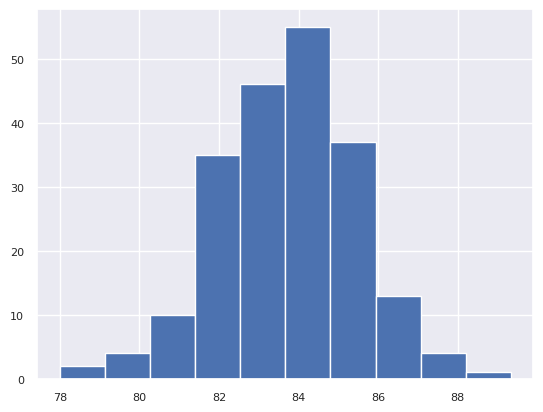

In [8]:
plt.hist(df["Total Cup Points"])
plt.show()

In [9]:
bajos = len(df[df["Total Cup Points"] <= 83])
mid = df[df["Total Cup Points"] < 85]
mid =  len(mid[mid["Total Cup Points"] > 83])
high = len(df[df["Total Cup Points"] >= 85])
print("Cantidad de valores bajos, medios y altos: ", bajos,mid,high)

Cantidad de valores bajos, medios y altos:  68 91 48


In [10]:

print(df.info()) #basic info of each variable

print("\nBasic Statistics of Each Variable\n")

print(df.describe()) #stats of each variable

print("ARE THERE MISSING VALUES?", df.isnull().values.any())#check whether any value is missing
print(df.isna().sum())#counts the number of missing values



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207 entries, 0 to 206
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             207 non-null    int64  
 1   ID                     207 non-null    int64  
 2   Country of Origin      207 non-null    object 
 3   Farm Name              205 non-null    object 
 4   Lot Number             206 non-null    object 
 5   Mill                   204 non-null    object 
 6   ICO Number             75 non-null     object 
 7   Company                207 non-null    object 
 8   Altitude               206 non-null    object 
 9   Region                 205 non-null    object 
 10  Producer               206 non-null    object 
 11  Number of Bags         207 non-null    int64  
 12  Bag Weight             207 non-null    object 
 13  In-Country Partner     207 non-null    object 
 14  Harvest Year           207 non-null    object 
 15  Gradin

Principalmente faltan valores de la columna ICO Number (>50%). La eliminaremos.

In [11]:
df = df.drop(["ICO Number"],axis=1)

Eliminaremos también las filas con valores faltantes ya que muchas son categóricas y no se pueden imputar correctamente

In [12]:
df = df.dropna(axis=0)

Visualizamos la distribución de variables categoricas y numericas por separado

In [13]:
numerical_columns = df.select_dtypes(include='number').columns
categorical_columns = df.select_dtypes(include='object').columns
categorical_columns


Index(['Country of Origin', 'Farm Name', 'Lot Number', 'Mill', 'Company',
       'Altitude', 'Region', 'Producer', 'Bag Weight', 'In-Country Partner',
       'Harvest Year', 'Grading Date', 'Owner', 'Variety', 'Status',
       'Processing Method', 'Color', 'Expiration', 'Certification Body',
       'Certification Address', 'Certification Contact'],
      dtype='object')

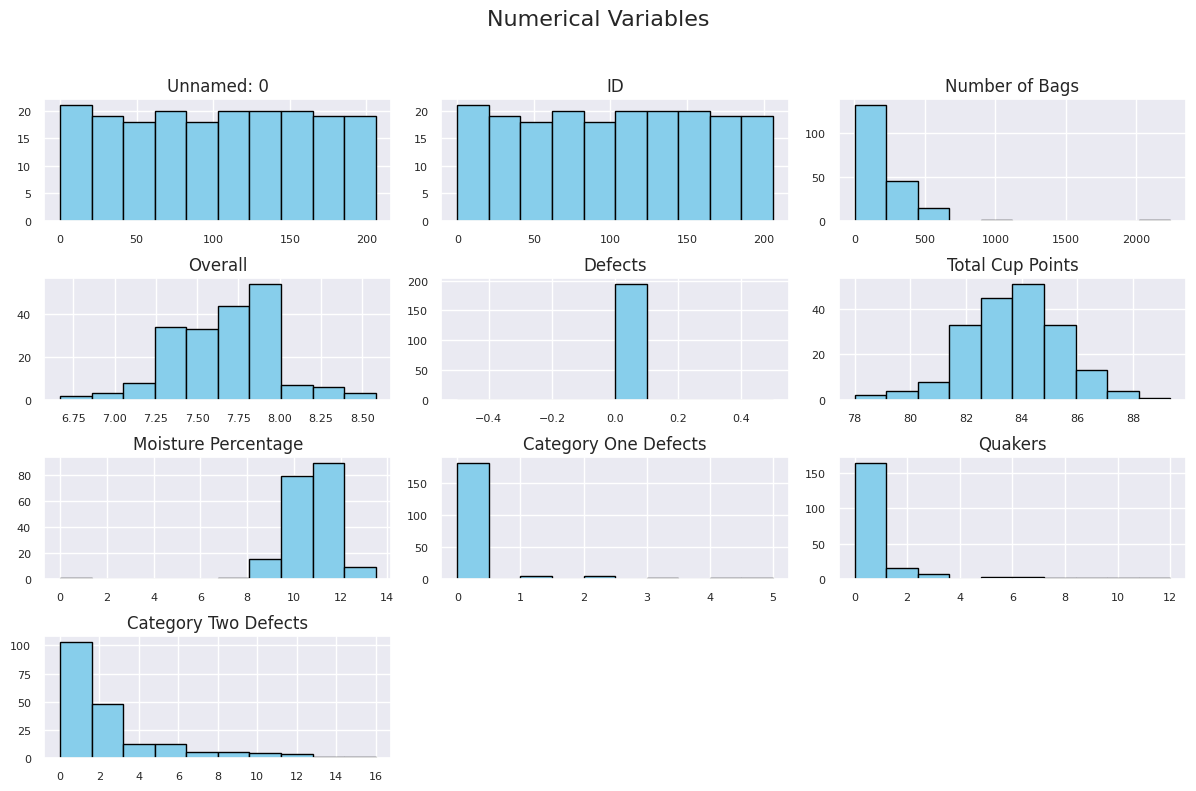

In [14]:

df_numeric = df[numerical_columns]

fig, ax = plt.subplots(4,3,figsize=(12,8))
fig.suptitle("Numerical Variables", fontsize=16)
ax = ax.flatten()

# Plot a histogram for each column
for i, col in enumerate(df_numeric.columns):
    ax[i].hist(df_numeric[col], bins=10, color='skyblue', edgecolor='black')
    ax[i].set_title(col)

# Hide any remaining empty subplots
for j in range(len(df_numeric.columns), len(ax)):
    fig.delaxes(ax[j])

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for title
plt.show()

Se puede eliminar Defects ya que es constante, e ID y Unnamed:0 por ser variables índices.

In [15]:
df = df.drop(["Defects","Unnamed: 0", "ID"],axis=1)

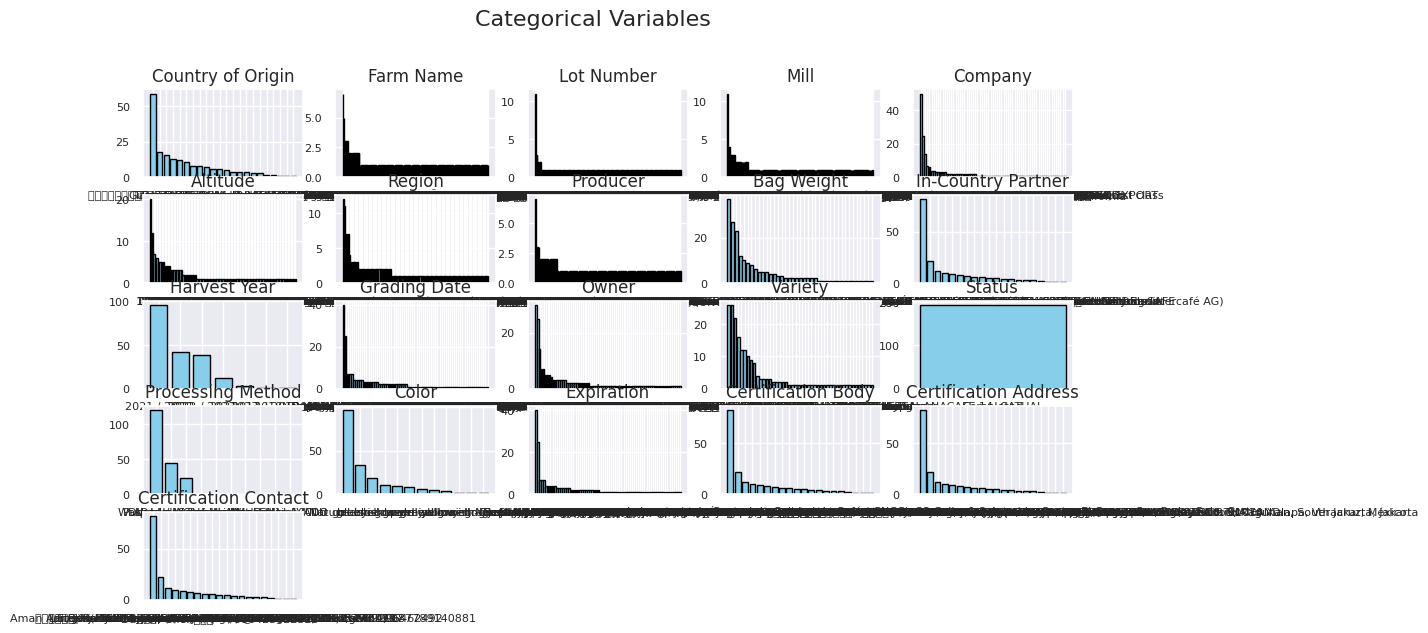

In [16]:

df_categorical = df[categorical_columns]

fig, ax = plt.subplots(6,5,figsize=(12,8))
fig.suptitle("Categorical Variables", fontsize=16)
ax = ax.flatten()

# Plot a histogram for each column
for i, col in enumerate(df_categorical.columns):
    counts = df_categorical[col].value_counts()
    ax[i].bar(counts.index, counts.values, color='skyblue', edgecolor='black')
    ax[i].set_title(col)

# Hide any remaining empty subplots
for j in range(len(df_categorical.columns), len(ax)):
    fig.delaxes(ax[j])

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for title
plt.show()

La mayor parte de los gráficos presentan distribuciones similares. Las variables categóricas tienen unos pocos valores muy comunes y una larga cola de valores distintos. Esto excepto Certification Adress, que termina teniendo un solo valor, y por ende se puede omitir del análisis.

In [17]:
df = df.drop(["Certification Address"],axis=1)

Vemos ahora correlación entre las variables numéricas


Correlations between the Variables



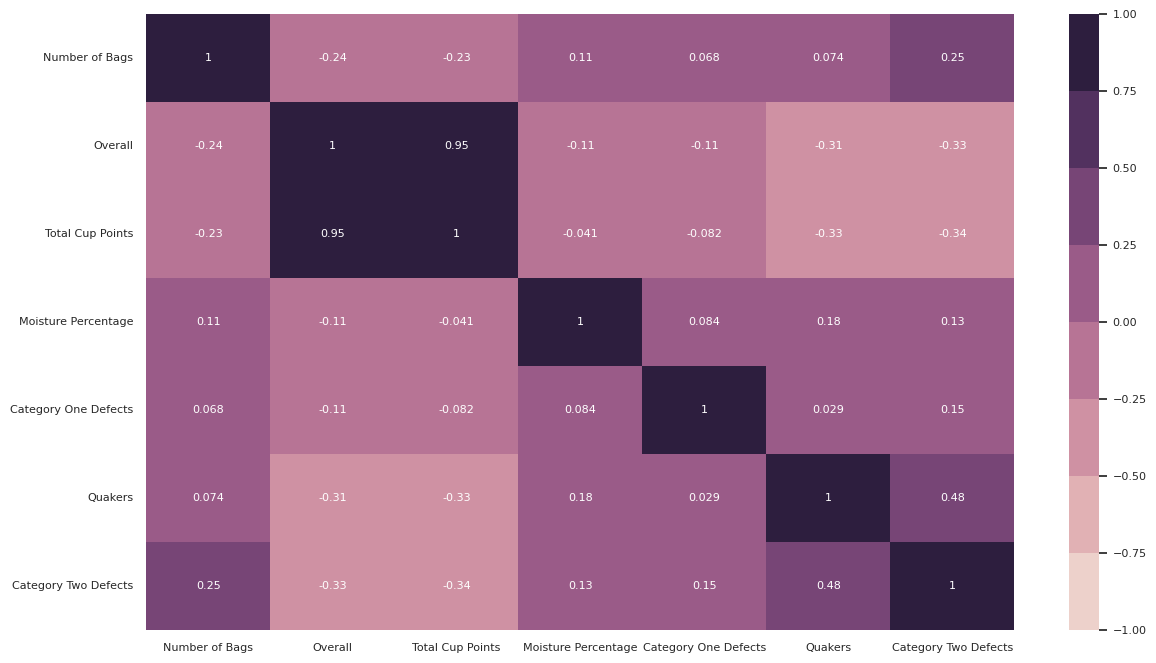

In [18]:
df_numerical = df[df.select_dtypes(include='number').columns]

plt.figure(figsize=(14, 8))
print('\nCorrelations between the Variables\n')
correlation = df_numerical.corr()
sns.heatmap(correlation, annot=True, linewidths=0, vmin=-1, cmap=sns.cubehelix_palette(8))
plt.show()

## Falta distribucion de cafes por cada nivel de calidad

### Data Preparation (Leandro)


#### Defining Two Classes (Nosotros empezamos con multiples clases, omitir esta)

In [19]:
coffee_df = df.copy(deep=True)

coffee_df = pd.get_dummies(coffee_df, columns=['Country of Origin', 'Farm Name', 'Lot Number', 'Mill', 'Company', 'Altitude', 'Region', 'Producer', 'Bag Weight', 'In-Country Partner', 'Harvest Year', 'Grading Date', 'Owner', 'Variety', 'Status', 'Processing Method', 'Color', 'Expiration', 'Certification Body', 'Certification Contact'])


coffee_df_binary['quality_binary'] = 0
coffee_df_binary.loc[coffee_df['Total Cup Points'] < 83, 'quality_binary'] = -1
coffee_df_binary.loc[coffee_df['Total Cup Points'] >= 84, 'quality_binary'] = +1

X = coffee_df_binary.drop(['Total Cup Points','quality_binary'], axis=1).values
y = coffee_df_binary['quality_binary'].values

rn = random.randint(0, 100000)#22078, 37918, 89186, 60162, 35038, 1183, 69668, 2784
rn = 22078; print("RANDOM STATE", rn);

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=rn)

coffee_df_train = pd.DataFrame(X_train,columns=coffee_df.columns[:-1])
coffee_df_train['quality_binary'] = y_train
print(coffee_df_train.describe()) #stats of each variable

fig, ax = plt.subplots(figsize=(10,4))
class_counts = coffee_df_train['quality_binary'].value_counts()
sns.barplot(x=class_counts.index, y=class_counts, palette="cubehelix")
ax.set_title('Number of wines per Quality') # Title
ax.set_ylabel('Number of wines') # Y label
ax.set_xlabel('Quality (Binary)') # X label
plt.show()

bad = coffee_df_train.loc[coffee_df_train['quality_binary'] == -1]
good = coffee_df_train.loc[coffee_df_train['quality_binary'] == 1]

fig, ax = plt.subplots(figsize=(9,8), nrows=4, ncols=3)
counter = 0
for var_name in coffee_df_train.columns:
  j = counter//4; i = counter%4;
  sns.distplot(bad[var_name].values, hist=False, rug=True, ax=ax[i,j])
  sns.distplot(good[var_name].values, hist=False, rug=True, ax=ax[i,j])
  counter +=1

plt.title(var_name)
plt.show()

NameError: name 'coffee_df_binary' is not defined

#### Scaling

In [ ]:
coffee_df = df.copy(deep=True)

# TODO: Chequear si usar encoding para variables categoricas ayuda
#coffee_df = pd.get_dummies(coffee_df, columns=['Country of Origin', 'Farm Name', 'Lot Number', 'Mill', 'Company', 'Altitude', 'Region', 'Producer', 'Bag Weight', 'In-Country Partner', 'Harvest Year', 'Grading Date', 'Owner', 'Variety', 'Status', 'Processing Method', 'Color', 'Expiration', 'Certification Body', 'Certification Contact'])
coffee_df = coffee_df.drop(['Country of Origin', 'Farm Name', 'Lot Number', 'Mill', 'Company', 'Altitude', 'Region', 'Producer', 'Bag Weight', 'In-Country Partner', 'Harvest Year', 'Grading Date', 'Owner', 'Variety', 'Status', 'Processing Method', 'Color', 'Expiration', 'Certification Body', 'Certification Contact'], axis=1)

coffee_df_binary = coffee_df.copy(deep=True)
coffee_df_binary['quality_binary'] = 0
coffee_df_binary.loc[coffee_df['Total Cup Points'] < 83, 'quality_binary'] = -1
coffee_df_binary.loc[coffee_df['Total Cup Points'] >= 84, 'quality_binary'] = +1

X = coffee_df_binary.drop(['Total Cup Points','quality_binary'], axis=1).values
y = coffee_df_binary['quality_binary'].values

rn = random.randint(0, 100000)#22078, 37918, 89186, 60162, 35038, 1183, 69668, 2784
rn = 22078; print("RANDOM STATE", rn);

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=rn)

scaler = StandardScaler(with_mean=True, with_std=True)
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

coffee_df_train = pd.DataFrame(X_train_scaled,columns=coffee_df.columns[:-1])
coffee_df_train['quality_binary'] = y_train
print(coffee_df_train.describe()) #stats of each variable

fig, ax = plt.subplots(figsize=(10,4))
class_counts = coffee_df_train['quality_binary'].value_counts()
sns.barplot(x=class_counts.index, y=class_counts, palette="cubehelix")
ax.set_title('Number of wines per Quality') # Title
ax.set_ylabel('Number of wines') # Y label
ax.set_xlabel('Quality (Binary)') # X label
plt.show()

fig, ax = plt.subplots(figsize=(9,8), nrows=4, ncols=3)
counter = 0
for var_name in coffee_df_train.columns:
  j = counter//4; i = counter%4;
  sns.distplot(bad[var_name].values, hist=False, rug=True, ax=ax[i,j])
  sns.distplot(good[var_name].values, hist=False, rug=True, ax=ax[i,j])
  counter +=1
  plt.title(var_name)

plt.tight_layout()
plt.show()

#### Outlier Removal


In [ ]:
print(coffee_df_train.info())#basic info of each variable
print(coffee_df_train.describe()) #stats of each variable

fig, ax = plt.subplots(figsize=(9,12), nrows=4, ncols=3)
counter = 0
for column in coffee_df_train.columns:
  j = counter//4; i = counter%4;
  sns.boxplot(x = column, data = coffee_df_train,ax=ax[i,j],palette="PuBuGn_d")
  ax[i,j].set_ylabel(column.capitalize()) # Y label
  counter +=1
plt.tight_layout()
plt.show()

col = 'chlorides'

Q1 = coffee_df_train[col].quantile(0.25)
Q3  = coffee_df_train[col].quantile(0.75)


IQR = Q3-Q1
coffee_train_filtered_df = coffee_df_train[coffee_df_train[col] < Q3 + 1.5*IQR]
coffee_train_filtered_df = coffee_train_filtered_df[coffee_df_train[col] > Q1 - 1.5*IQR]

print(coffee_train_filtered_df .info())#basic info of each variable
print(coffee_train_filtered_df .describe()) #stats of each variable


### Linear SVM Definition and Training (Ivan)

#### Default Parameters

In [ ]:
from sklearn.svm import SVC
class_weights = dict()

class_weights[0] = 10
class_weights[1] = 0.1

#svm = SVC(kernel='linear', C=1,class_weight=class_weights)
svm = SVC(kernel='linear',C=10)

svm.fit(X_train_scaled,y_train)

print("GLOBAL ACCURACY TRAIN SET (LIB)",svm.score(X_train_scaled,y_train))
print("GLOBAL ACCURACY TEST SET (LIB)",svm.score(X_test_scaled,y_test))

print("\nDETAILED REPORT TEST SET:\n")
print(classification_report(y_test, svm.predict(X_test_scaled), target_names=["bad","good"]))

#### Effect of Regularization Parameter (C)

In [ ]:
from sklearn.svm import SVC

C_values = np.logspace(-3, 3, num=7, endpoint=True, base=10.0)
print(C_values)

test_accuracy = []
train_accuracy = []

for C_val in C_values:
  svm = SVC(kernel='linear', C=C_val)
  svm.fit(X_train_scaled,y_train)
  train_accuracy.append(svm.score(X_train_scaled,y_train))
  test_accuracy.append(svm.score(X_test_scaled,y_test))


fig, ax = plt.subplots(figsize=(10,10))
ax.plot(np.log(C_values),train_accuracy,color='g',lw=2.,label='train_acc')
ax.plot(np.log(C_values),test_accuracy,color='r',lw=2.5,label='test_acc')
plt.title("Test and Train Accuracy versus Value of C")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


#### Model Selection (USING A VALIDATION SET)

In [ ]:
from sklearn.model_selection import train_test_split
import random, sys

rn = random.randint(0, 100000)
print(rn)#1158
rn = 1158

X_train_sel, X_val, y_train_sel, y_val = train_test_split(X_train_scaled, y_train, test_size=0.33, random_state=rn)

C_values = np.logspace(-3, 3, num=7, endpoint=True, base=10.0)
print(C_values)

test_accuracy = []
val_accuracy = []
train_accuracy = []

for C_val in C_values:
  svm = SVC(kernel='linear', C=C_val)
  svm.fit(X_train_sel,y_train_sel)
  train_accuracy.append(svm.score(X_train_sel,y_train_sel))
  val_accuracy.append(svm.score(X_val,y_val))
  test_accuracy.append(svm.score(X_test_scaled,y_test))


fig, ax = plt.subplots(figsize=(10,10))
ax.plot(np.log(C_values),train_accuracy,color='g',lw=2.,label='train_acc')
ax.plot(np.log(C_values),val_accuracy,color='y',lw=2.,label='val_acc')
ax.plot(np.log(C_values),test_accuracy,color='r',lw=2.5,label='test_acc')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Accuracy versus Value of C")
plt.show()

#### Model Selection (USING CROSS-VALIDATION)

In [ ]:
from sklearn.model_selection import GridSearchCV

parameters = {'kernel':['linear'], 'C': np.logspace(-3, 3, num=7, endpoint=True, base=10.0)}
svm = SVC()
gs = GridSearchCV(svm, parameters,return_train_score=True)
gs.fit(X_train_scaled,y_train)


fig, ax = plt.subplots(figsize=(10,10))
ax.plot(np.log(C_values),gs.cv_results_['mean_train_score'],color='g',lw=1.5,label='train_acc')
ax.plot(np.log(C_values),gs.cv_results_['mean_test_score'],color='y',lw=2.5,label='cv_acc')
plt.fill_between(np.log(C_values), gs.cv_results_['mean_test_score']-gs.cv_results_['std_test_score'], gs.cv_results_['mean_test_score']+gs.cv_results_['std_test_score'],color='gray', alpha=0.2)
plt.title("CV Accuracy versus Value of C")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


### Non-linear SVM Definition and Training (Ivan)

#### Default Parameters


In [ ]:
from sklearn.svm import SVC
class_weights = dict()

class_weights[0] = 10
class_weights[1] = 0.1

#svm = SVC(kernel='linear', C=1,class_weight=class_weights)
svm = SVC(kernel='rbf')

svm.fit(X_train_scaled,y_train)

print("GLOBAL ACCURACY TRAIN SET (LIB)",svm.score(X_train_scaled,y_train))
print("GLOBAL ACCURACY TEST SET (LIB)",svm.score(X_test_scaled,y_test))

print("\nDETAILED REPORT TEST SET:\n")
print(classification_report(y_test, svm.predict(X_test_scaled), target_names=["bad","good"]))

#### Effect of Regularization Parameter

In [ ]:
from sklearn.svm import SVC

C_values = np.logspace(-3, 4, num=8, endpoint=True, base=10.0)
print(C_values)

test_accuracy = []
train_accuracy = []

for C_val in C_values:
  svm = SVC(kernel='rbf', C=C_val)
  svm.fit(X_train_scaled,y_train)
  train_accuracy.append(svm.score(X_train_scaled,y_train))
  test_accuracy.append(svm.score(X_test_scaled,y_test))


fig, ax = plt.subplots(figsize=(10,10))
ax.plot(np.log(C_values),train_accuracy,color='g',lw=2.,label='train_acc')
ax.plot(np.log(C_values),test_accuracy,color='r',lw=2.5,label='test_acc')
plt.title("Test and Train Accuracy versus Value of C")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


#### Model Selection - I

In [ ]:
from sklearn.model_selection import train_test_split
import random, sys

rn = random.randint(0, 100000)
print(rn)#1158
rn = 1158

X_train_sel, X_val, y_train_sel, y_val = train_test_split(X_train_scaled, y_train, test_size=0.33, random_state=rn)

C_values = np.logspace(-3, 4, num=8, endpoint=True, base=10.0)
print(C_values)

test_accuracy = []
val_accuracy = []
train_accuracy = []

for C_val in C_values:
  svm = SVC(kernel='rbf', C=C_val)
  svm.fit(X_train_sel,y_train_sel)
  train_accuracy.append(svm.score(X_train_sel,y_train_sel))
  val_accuracy.append(svm.score(X_val,y_val))
  test_accuracy.append(svm.score(X_test_scaled,y_test))


fig, ax = plt.subplots(figsize=(10,10))
ax.plot(np.log(C_values),train_accuracy,color='g',lw=2.,label='train_acc')
ax.plot(np.log(C_values),val_accuracy,color='y',lw=2.,label='val_acc')
ax.plot(np.log(C_values),test_accuracy,color='r',lw=2.5,label='test_acc')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Accuracy versus Value of C")
plt.show()

#### Model Selection II

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

C_values = np.logspace(-3, 4, num=8, endpoint=True, base=10.0)
print(C_values)

test_accuracy = []
cross_val_accuracy = []
cross_val_std = []
train_accuracy = []

for C_val in C_values:
  svm = SVC(kernel='rbf', C=C_val)
  cv_output = cross_val_score(svm, X_train_scaled, y_train, cv=5)
  cross_val_accuracy.append(cv_output.mean())
  cross_val_std.append(cv_output.std())
  svm = SVC(kernel='rbf', C=C_val)
  svm.fit(X_train_scaled,y_train)
  train_accuracy.append(svm.score(X_train_scaled,y_train))
  test_accuracy.append(svm.score(X_test_scaled,y_test))

cross_val_accuracy = np.array(cross_val_accuracy)
cross_val_std = np.array(cross_val_std)

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(np.log(C_values),train_accuracy,color='g',lw=2.,label='train_acc')
ax.plot(np.log(C_values),cross_val_accuracy,color='y',lw=2.5,label='cv_acc')
plt.fill_between(np.log(C_values), cross_val_accuracy-cross_val_std, cross_val_accuracy+cross_val_std,color='gray', alpha=0.2)
ax.plot(np.log(C_values),test_accuracy,color='r',lw=2.5,label='test_acc')
plt.title("CV, Test, Train Accuracy versus Value of C")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


#### Model Selection III

In [ ]:
#### TUNE THE KERNELIZED MACHINE
print("\nTUNNING TWO PARAMETERS OF A NON-LINEAR SVM ...\n")
parameters_rbf = {'C': np.logspace(-3, 4, num=8, endpoint=True, base=10.0), 'gamma': [0.01, 0.1], 'kernel': ['rbf']}

svm = SVC()
grid_result_rbf = GridSearchCV(svm, parameters_rbf,return_train_score=True)
grid_result_rbf.fit(X_train_scaled,y_train)

means = grid_result_rbf.cv_results_['mean_test_score']
stds = grid_result_rbf.cv_results_['std_test_score']
params = grid_result_rbf.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))#param is a dict with the fields you created
    #print(param['kernel'],param['C'])#you can access the fields to see the param values

print("\nBEST RESULTS FOR NON-LINEAR SVM ...\n")
print("PARAMS: ",grid_result_rbf.best_params_)
print("SCORE: ",grid_result_rbf.best_score_)

#### TUNE THE LINEAR MACHINE AND NON-LINEAR AT THE SAME TIME
print("\nTUNNING THE SVM INCLUDING DIFFERENT KERNELS ...\n")
parameters = [
  {'C': np.logspace(-1, 1, num=3, endpoint=True, base=10.0), 'kernel': ['linear']},
  {'C': np.logspace(-1, 1, num=3, endpoint=True, base=10.0), 'gamma': [0.01, 0.02, 0.1, 0.2], 'kernel': ['rbf']},
 ]

svm = SVC()
grid_result = GridSearchCV(svm, parameters,return_train_score=True)
grid_result.fit(X_train_scaled,y_train)

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))#param is a dict with the fields you created
    #print(param['kernel'],param['C'])#you can access the fields to see the param values

print("\nBEST RESULTS ...\n")
print("PARAMS: ",grid_result.best_params_)
print("SCORE: ",grid_result.best_score_)


### Examining the Linear Model (Benja)


In [ ]:
svm = SVC(kernel='linear', C=1)
svm.fit(X_train_scaled,y_train)

w = svm.coef_[0]
b = svm.intercept_[0]

#print(w.shape)
print("VALUE OF INTERCEPT", b)
print("PERC. POSITIVE CLASS:", np.sum(y_train==1)/len(y_train))
print("PERC. NEGATIVE CLASS:", np.sum(y_train==0)/len(y_train))

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))
var_idx = range(0,len(w))
ax.barh(var_idx, w, align='center')
ax.set_yticks(var_idx)
ax.set_yticklabels(wine_df_train.columns[:-1])
plt.title("SVM Weights")
plt.show()



### Support Vectors in the Linear and Non-linear Model (Benja)

# COSAS UTILES

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X_train_scaled)
X_train_proyected = pca.transform(X_train_scaled)
y_pred_train = svm.predict(X_train_scaled)
decision_train = svm.decision_function(X_train_scaled)

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(X_train_proyected[:,0],X_train_proyected[:,1],c=y_train)

X_mistakes = X_train_scaled[y_train != y_pred_train]
X_mistakes_proyected = pca.transform(X_mistakes)
#ax.scatter(X_mistakes_proyected[:,0],X_mistakes_proyected[:,1], s=280, facecolors='none',edgecolors='r',linewidth=3.5)

sv = svm.support_vectors_ #support vectors
nsv = svm.n_support_ #number of support vectors
sv_idx = svm.support_ #indices of support vectors
sv_proyected = pca.transform(sv)

print("NUMBER OF SUPPORT VECTORS %d", nsv)

ax.scatter(sv_proyected[:,0],sv_proyected[:,1], s=180, facecolors='none',edgecolors='m',linewidth=2)

plt.title("Mistakes and Support Vectors Found by the SVM")
plt.show()



### Training for Multiple Classes

#### Preparing the Data

In [ ]:
wine_df_multi = wine_df.copy(deep=True)
wine_df_multi['quality_multi'] = 0
wine_df_multi.loc[wine_df['quality'] <= 5, 'quality_multi'] = 0
wine_df_multi.loc[(wine_df['quality'] > 5) & (wine_df['quality'] <= 6), 'quality_multi'] = 1
wine_df_multi.loc[wine_df['quality'] >= 7, 'quality_multi'] = 2

X = wine_df_multi.drop(['quality','quality_multi'], axis=1).values
y = wine_df_multi['quality_multi'].values

print(np.unique(y))

rn = random.randint(0, 100000)#22078, 37918, 89186, 60162, 35038, 1183, 69668, 2784
rn = 22078; print("RANDOM STATE", rn);

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=rn)

scaler = StandardScaler(with_mean=True, with_std=True)
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

wine_df_train = pd.DataFrame(X_train_scaled,columns=wine_df.columns[:-1])
wine_df_train['quality_multi'] = y_train
print(wine_df_train.describe()) #stats of each variable

fig, ax = plt.subplots(figsize=(10,4))
class_counts = wine_df_train['quality_multi'].value_counts()
sns.barplot(x=class_counts.index, y=class_counts, palette="cubehelix")
ax.set_title('Number of wines per Quality') # Title
ax.set_ylabel('Number of wines') # Y label
ax.set_xlabel('Quality (Multiple Levels)') # X label
plt.show()

fig, ax = plt.subplots(figsize=(9,8), nrows=4, ncols=3)
counter = 0
for column in wine_df_train.columns:
  if column != 'quality': #we skip the variable original quality -> 0-10
    j = counter//4; i = counter%4;
    sns.barplot(x = 'quality_multi', y = column, data = wine_df_train,ax=ax[i,j],palette="cubehelix")
    #ax[i,j].set_title('%s versus quality'%column.capitalize())
    ax[i,j].set_ylabel(column) # Y label
    #ax[i,j].set_xlabel('Quality (Binary)') # X label
    counter +=1
plt.tight_layout()
plt.show()




#### Model Training and Evaluation


In [ ]:
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OutputCodeClassifier
from sklearn.multiclass import OneVsRestClassifier

svm = OneVsRestClassifier(SVC(kernel='rbf',C=1))
svm.fit(X_train_scaled,y_train)

print("OVR ACCURACY TRAIN SET (LIB)",svm.score(X_train_scaled,y_train))
print("OVR ACCURACY TEST SET (LIB)",svm.score(X_test_scaled,y_test))

#print("\nOVR DETAILED REPORT TEST SET:\n")
#print(classification_report(y_test, svm.predict(X_test_scaled), target_names=["bad","average","good"]))


svm = OneVsOneClassifier(SVC(kernel='rbf',C=1))
svm.fit(X_train_scaled,y_train)

print("OVO ACCURACY TRAIN SET (LIB)",svm.score(X_train_scaled,y_train))
print("OVO ACCURACY TEST SET (LIB)",svm.score(X_test_scaled,y_test))

#print("\nOVO DETAILED REPORT TEST SET:\n")
#print(classification_report(y_test, svm.predict(X_test_scaled), target_names=["bad","average","good"]))


svm = OutputCodeClassifier(SVC(kernel='rbf',C=1),code_size=10)
svm.fit(X_train_scaled,y_train)

print("ECOC ACCURACY TRAIN SET (LIB)",svm.score(X_train_scaled,y_train))
print("ECOC ACCURACY TEST SET (LIB)",svm.score(X_test_scaled,y_test))

#print("\nECOC DETAILED REPORT TEST SET:\n")
#print(classification_report(y_test, svm.predict(X_test_scaled), target_names=["bad","average","good"]))




### Evaluating the Models beyond Accuracy

In [ ]:
from sklearn.svm import SVC
class_weights = dict()

class_weights[0] = 10
class_weights[1] = 0.1

#svm = SVC(kernel='linear', C=1,class_weight=class_weights)
svm = SVC(kernel='rbf')

svm.fit(X_train_scaled,y_train)

print("GLOBAL ACCURACY TRAIN SET (LIB)",svm.score(X_train_scaled,y_train))
print("GLOBAL ACCURACY TEST SET (LIB)",svm.score(X_test_scaled,y_test))

print("\nDETAILED REPORT TEST SET:\n")
#print(classification_report(y_test, svm.predict(X_test_scaled), target_names=["bad","good"]))
print(classification_report(y_test, svm.predict(X_test_scaled), target_names=["bad","average","good"]))

### Dealing with Unbalanced Data

In [ ]:
wine_df_binary = wine_df.copy(deep=True)
wine_df_binary['quality_binary'] = 0
wine_df_binary.loc[wine_df['quality'] < 4.5, 'quality_binary'] = 0
wine_df_binary.loc[wine_df['quality'] >= 4.5, 'quality_binary'] = 1

X = wine_df_binary.drop(['quality','quality_binary'], axis=1).values
y = wine_df_binary['quality_binary'].values

rn = random.randint(0, 100000)#22078, 37918, 89186, 60162, 35038, 1183, 69668, 2784
rn = 22078; print("RANDOM STATE", rn);

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=rn)

scaler = StandardScaler(with_mean=True, with_std=True)
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

final_df = pd.DataFrame(X_train_scaled)
final_df["Class"] = y_train
class_counts = final_df["Class"].value_counts()
plt.figure(figsize=(6,3))
sns.barplot(x=class_counts.index, y=class_counts)
plt.title('Class Distribution after Under and Over Sampling')
plt.ylabel('Count')
plt.xlabel('Class (0:Bad, 1:Good)')
plt.show()

from sklearn.svm import SVC
class_weights = dict()

#class_weights[0] = 1
#class_weights[1] = 2

#svm = SVC(kernel='linear', C=1,class_weight=class_weights)
svm = SVC(kernel='rbf')

svm.fit(X_train_scaled,y_train)

print("GLOBAL ACCURACY TRAIN SET (LIB)",svm.score(X_train_scaled,y_train))
print("GLOBAL ACCURACY TEST SET (LIB)",svm.score(X_test_scaled,y_test))

print("\nDETAILED REPORT TEST SET:\n")
print(classification_report(y_test, svm.predict(X_test_scaled), target_names=["bad","good"]))


In [ ]:
wine_df_binary = wine_df.copy(deep=True)
wine_df_binary['quality_binary'] = 0
wine_df_binary.loc[wine_df['quality'] < 4.5, 'quality_binary'] = 0
wine_df_binary.loc[wine_df['quality'] >= 4.5, 'quality_binary'] = 1

X = wine_df_binary.drop(['quality','quality_binary'], axis=1).values
y = wine_df_binary['quality_binary'].values

rn = random.randint(0, 100000)#22078, 37918, 89186, 60162, 35038, 1183, 69668, 2784
rn = 22078; print("RANDOM STATE", rn);

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=rn)

final_df = pd.DataFrame(X_train)
final_df["Class"] = y_train
class_counts = final_df["Class"].value_counts()
plt.figure(figsize=(6,3))
sns.barplot(x=class_counts.index, y=class_counts)
plt.title('Class Distribution after UnderSampling')
plt.ylabel('Count')
plt.xlabel('Class (0:Bad, 1:Good)')
plt.show()

print(X_train.shape,y_train.shape)
print(np.sum(y_train==0))
print(np.sum(y_train==1))

under = RandomUnderSampler(sampling_strategy=0.5,random_state=rn)
X_train, y_train = under.fit_resample(X_train, y_train)
#X_test, y_test = under.fit_resample(X_test, y_test)

print(X_train.shape,y_train.shape)

final_df = pd.DataFrame(X_train)
final_df["Class"] = y_train
class_counts = final_df["Class"].value_counts()
plt.figure(figsize=(6,3))
sns.barplot(x=class_counts.index, y=class_counts)
plt.title('Class Distribution after UnderSampling')
plt.ylabel('Count')
plt.xlabel('Class (0:Bad, 1:Good)')
plt.show()

over = SMOTE(sampling_strategy=1,random_state=rn)
X_train, y_train = over.fit_resample(X_train, y_train)
#X_test, y_test = over.fit_resample(X_test, y_test)

print(X_train.shape,y_train.shape)

scaler = StandardScaler(with_mean=True, with_std=True)
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

final_df = pd.DataFrame(X_train_scaled)
final_df["Class"] = y_train
class_counts = final_df["Class"].value_counts()
plt.figure(figsize=(6,3))
sns.barplot(x=class_counts.index, y=class_counts)
plt.title('Class Distribution after Under and Over Sampling')
plt.ylabel('Count')
plt.xlabel('Class (0:Bad, 1:Good)')
plt.show()



In [ ]:
from sklearn.svm import SVC
class_weights = dict()

class_weights[0] = 1
class_weights[1] = 5

#svm = SVC(kernel='linear', C=1,class_weight=class_weights)
svm = SVC(kernel='rbf',C=1,class_weight=class_weights)

svm.fit(X_train_scaled,y_train)

print("GLOBAL ACCURACY TRAIN SET (LIB)",svm.score(X_train_scaled,y_train))
print("GLOBAL ACCURACY TEST SET (LIB)",svm.score(X_test_scaled,y_test))

print("\nDETAILED REPORT TEST SET:\n")
print(classification_report(y_test, svm.predict(X_test_scaled), target_names=["bad","good"]))

### Feature Engineering


In [ ]:
wine_df_expanded = wine_df.copy(deep=True)

for column in wine_df.columns:
  if column != 'quality':
    name_new_col = 'log-%s'%column
    wine_df_expanded[name_new_col]=np.log10(wine_df[column].values + 1.0)
    #wine_df_expanded = wine_df_expanded.drop([column], axis=1)

print("\nRug Plots and Approximate Distribution of Each Variable\n")

fig, ax = plt.subplots(figsize=(9,12), nrows=4, ncols=3)
counter = 0
for column in wine_df_expanded.columns:
  print(column)
  if column.startswith('log-'):
    j = counter//4; i = counter%4;
    print(i,j)
    sns.distplot(wine_df_expanded[column].values,ax=ax[i,j],rug=True)
    ax[i,j].set_title(column.capitalize())
    counter += 1

plt.subplots_adjust(hspace=0.5)
plt.tight_layout()
plt.show()


In [ ]:
wine_df_multi_expanded = wine_df.copy(deep=True)
wine_df_multi_expanded['quality_multi'] = 0
wine_df_multi_expanded.loc[wine_df_expanded['quality'] <= 5, 'quality_multi'] = 0
wine_df_multi_expanded.loc[(wine_df_expanded['quality'] > 5) & (wine_df_expanded['quality'] <= 6), 'quality_multi'] = 1
wine_df_multi_expanded.loc[wine_df_expanded['quality'] >= 7, 'quality_multi'] = 2

X = wine_df_multi.drop(['quality','quality_multi'], axis=1).values
y = wine_df_multi['quality_multi'].values


rn = random.randint(0, 100000)#22078, 37918, 89186, 60162, 35038, 1183, 69668, 2784
rn = 22078; print("RANDOM STATE", rn);

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=rn)

scaler = StandardScaler(with_mean=True, with_std=True)
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
from sklearn.svm import SVC
class_weights = dict()

print(X_train_scaled.shape)
svm = SVC(kernel='rbf',C=1)

svm.fit(X_train_scaled,y_train)

print("GLOBAL ACCURACY TRAIN SET (LIB)",svm.score(X_train_scaled,y_train))
print("GLOBAL ACCURACY TEST SET (LIB)",svm.score(X_test_scaled,y_test))

print("\nDETAILED REPORT TEST SET:\n")
print(classification_report(y_test, svm.predict(X_test_scaled), target_names=["bad","average","good"]))